In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pandas as pd
import src
import sklearn

In [3]:
pwd = os.getcwd()
root = os.path.dirname(pwd)
data_folder = os.path.join(root, 'data')

In [4]:
df = pd.read_csv(os.path.join(data_folder, 'train.csv'))

In [5]:
def na_summary(df):
    na_count = df.isna().sum()
    na_percentage = (na_count / len(df)) * 100
    summary_df = pd.DataFrame({
        'variables': na_count.index,
        'na_count': na_count.values,
        'na_share': na_percentage.values
    })
    summary_df.sort_values(by='na_share', inplace=True, ascending=False)
    summary_df.reset_index(drop=True, inplace=True)
    return summary_df

In [6]:
def proportion_summary(df, x_variable, y_variable, not_na=False):    
    if not_na:
        filtered_df = df[df[x_variable].notna()]
    else:
        filtered_df = df[df[x_variable].isna()]

    counts = filtered_df[y_variable].value_counts()
    share = (counts / counts.sum()) * 100
    result_df = pd.DataFrame({
        'count': counts,
        'share': round(share, 2)
    })
    result_df.sort_index(inplace=True)

    return result_df

In [7]:
def proportion_x_to_y(df, x_variable, y_variable):
    group_counts = df.groupby([x_variable, y_variable]).size()
    total_counts = group_counts.groupby(level=0).sum()
    proportion = group_counts / total_counts
    proportion_df = proportion.reset_index(name='Proportion')
    return proportion_df

In [51]:
# Data set is not unbalanced 
round(df['Survived'].value_counts() / len(df), 2)

Survived
0    0.62
1    0.38
Name: count, dtype: float64

In [8]:
na_summary(df)

,variables,na_count,na_share
0,Cabin,687,77.104377
1,Age,177,19.865320
2,Embarked,2,0.224467
3,PassengerId,0,0.000000
4,Name,0,0.000000
5,Pclass,0,0.000000
6,Survived,0,0.000000
7,Sex,0,0.000000
8,Parch,0,0.000000
9,SibSp,0,0.000000


In [9]:
proportion_summary(df, 'Cabin', 'Survived')

,count,share
Survived,,
0,481,70.01
1,206,29.99


In [10]:
# Cabin wil be dropped. NAN are more than 75%
# Survived proportion is different from NAN to non-NAN values, but 75%+ of NAN are too much
proportion_summary(df, 'Cabin', 'Survived', True)

,count,share
Survived,,
0,68,33.33
1,136,66.67


In [11]:
df[df['Cabin'].notna()]['Survived'].value_counts()

Survived
1    136
0     68
Name: count, dtype: int64

In [12]:
# Drop rows with Embarked as NA because all of them are the same Survived category
# Maybe they were not in the ship 

df[df['Embarked'].isna()]['Survived'].value_counts()

Survived
1    2
Name: count, dtype: int64

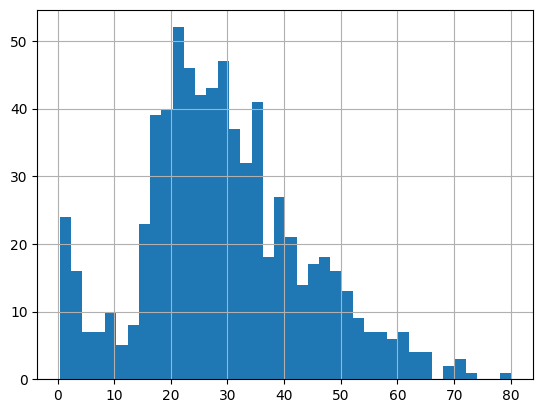

In [13]:
# Age has a fairly good distribution, so we can replace NAN values with the median
# It will be bins 
# 0 - 10
# 11 - 20
# 21 - 30
# 31 - 40
# 41 - 50
# 50 +

df['Age'].hist(bins=40);

In [14]:
df['Age'].median()

28.0

In [15]:
df['family_size'] = df['Parch'] + df['SibSp'] + 1

In [16]:
p = proportion_x_to_y(df, 'family_size', 'Survived')

In [17]:
# I will create a boolean variable for family_size between 2 and 4
p[p['Survived'] == 1]

,family_size,Survived,Proportion
1,1,1,0.303538
3,2,1,0.552795
5,3,1,0.578431
7,4,1,0.724138
9,5,1,0.200000
11,6,1,0.136364
13,7,1,0.333333


# Model 

In [18]:
col_label = 'Survived'

In [19]:
train = pd.read_csv(os.path.join(data_folder, 'train.csv'))
x_test = pd.read_csv(os.path.join(data_folder, 'test.csv'))
y_test = pd.read_csv(os.path.join(data_folder, 'gender_submission.csv'))[[col_label]]

In [20]:
fit_model = src.fit_model.FitModel()

In [21]:
grid = fit_model.execute(df=train)

In [22]:
model = grid.best_estimator_

In [23]:
predictions = model.predict(x_test)

In [24]:
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
f1 = sklearn.metrics.f1_score(y_test, predictions, average="macro")

In [49]:
print(f"f1: {round(f1, 2)}")
print(f"accuracy: {round(accuracy, 2)}")

f1: 0.86
accuracy: 0.87


### Conclusion about the model

I consider this a good model.
The F1-score is 0.86 which shows the model is effectively classifying positive and negative cases.

In [48]:
importance_df = pd.DataFrame(
    {
        'variable': model[-2].get_feature_names_out().tolist(),
        'importance': model[-1].feature_importances_.tolist()
    }
)
importance_df.sort_values('importance', ascending=False, inplace=True)
importance_df.reset_index(drop=True, inplace=True)
importance_df

,variable,importance
0,min_max__fare_log,0.289207
1,ohe_engineering__Sex_female,0.197976
2,ohe_engineering__Sex_male,0.181257
3,remainder__Pclass,0.128784
4,remainder__small_family,0.047752
5,ohe_engineering__Age_child,0.042192
6,ohe_engineering__Age_young_adult,0.020908
7,ohe_engineering__Embarked_S,0.018790
8,ohe_engineering__Age_teen_plus,0.018394
9,ohe_engineering__Embarked_C,0.015298


### Feature Importance

The four more important variables are:
1. Fare
2. Sex (female)
3. Sex (male)
4. Pclass

Not all the variables represents the same for the model, and these four variables represent almost 80% of the model capacity.
Fare (28.92%) has the biggest impact, it could be related to the economic purchase power and rooms maybe closer to lifeboats.
Sex (female 19.79%) is the second and sex (male 18.12%) are the second and third more important variables; it maybe related to "children and women first" rescue mindset.
Pclass (12.87%) it is highly related to the economic purchase power that may put the passengers close to the lifeboats.

### Architecture

The model could be deployed as a SageMaker endpoint or a as a service on a ECS cluster.


### Automate 

I would have a MLFlow server running, connected to RDS and S3.
After that, (1) a SageMaker job could be trigger from an AWS Lambda scheduled with an EventBridge, or (2) do it directly on a EC2 instance dedicated for that.


The reason of using this services is that they can provide a simple, straight forward, and scalable way to go to prod and keep the model updated.

